# Data

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
dfCCO = pd.read_csv('cco_cost_monthly.csv')

In [5]:
dfPYCO = pd.read_csv('pyco_cost_monthly.csv', low_memory=False)

In [6]:
dfXCO = pd.read_csv('xco_cost_monthly.csv')

In [7]:
dfTotal = pd.concat([dfCCO, dfPYCO, dfXCO], axis=0)

In [8]:
# First start the creation of our final dataframe, starting with total monthly cost
def process_dataframe(df, fillna=True):
    """
    Processes a dataFrame from what's initially given to a usable form for our model.
    """
    dfProcessed = df.groupby("invoice_month").agg({"total_cost": "sum"})
    products = dfTotal["product_name"].unique()
    # Loops through all of the unique product names
    for product in products:
        # Grabs the monthly total cost and usage for each product
        df_product_monthly = df.loc[df["product_name"] == product].groupby("invoice_month").agg({"total_cost": "sum", "usage_amount": "sum"}).rename(columns={"total_cost" : product + " cost", "usage_amount": product + " usage"})
        #Concatenates that onto the total dataframe we have
        dfProcessed = pd.concat([dfProcessed, df_product_monthly], axis=1)
        dfProcessed.columns = dfProcessed.columns.str.replace(' ', '_')
        
    if fillna==True:    
        dfProcessed = dfProcessed.fillna(0)
    
    
    return dfProcessed

In [9]:
def selectFeatures(df):
    coli = ["total_cost", "Amazon_Elastic_Compute_Cloud_cost", "Amazon_Relational_Database_Service_cost", "Amazon_Simple_Storage_Service_cost", "Amazon_DocumentDB_(with_MongoDB_compatibility)_cost" , "Amazon_Elastic_File_System_cost"]
    dfVoi = df[coli]
    dfVoi.columns = dfVoi.columns.str.replace('Amazon_', '')
    dfVoi.columns = dfVoi.columns.str.replace('_(with_MongoDB_compatibility)_', '_')
    
    return dfVoi

In [10]:
def testTrainSplit(df, split):
    test = df[:int((len(df))*split)]
    train = df[int((len(df))*split):]
    
    return train, test

In [11]:
def irvTrainSplit(X, y, split):
    """
    Split the test and train data for the target variable and features. Modification by Irvin from the previous testTrainSplit created by Upayan.
    """
    
    # Get shape of first dimension of tensor and say what needs to be split to get the last X datapoints to be dropped from the training and into the testing
    splitter = int(X.shape[0]*split)
    test_X = X[splitter:]
    train_X = X[:splitter]
    test_y = y[splitter:]
    train_y = y[:splitter]
    
    print('X train shape == {}.'.format(train_X.shape))
    print('Y train shape == {}.'.format(train_y.shape))
    print('X test shape == {}.'.format(test_X.shape))
    print('Y test shape == {}.'.format(test_y.shape))
    
    return train_X, test_X, train_y, test_y

In [12]:
def to_supervised (df_for_training, n_future, n_past):
    trainX = []
    trainY = []

    for i in range(n_past, len(df_for_training) - n_future +1):
        trainX.append(df_for_training[i - n_past:i, 0:df_for_training.shape[1]])
        trainY.append(df_for_training[i + n_future - 1:i + n_future, 0])

    trainX, trainY = np.array(trainX), np.array(trainY)

    print('X shape == {}.'.format(trainX.shape))
    print('Y shape == {}.'.format(trainY.shape))
    
    return trainX, trainY


In [13]:
def dataProcessNew(df, split, n_future, n_past, name):
    """
    Remade by Irvin so that test/train split actually works (requires you to process data, then split tensors). Also added more dictionary items.
    This should likely be an object with this function as the __init__, but there's no time to fix our datatypes.
    """
    dfProcessed = process_dataframe(df, fillna=True)
    months = dfProcessed.index
    ss = StandardScaler()
    dfScaled = ss.fit_transform(dfProcessed)
    X, y = to_supervised(dfScaled, n_future, n_past)
    trainX, testX, trainy, testy =  irvTrainSplit(X, y, split)
    
    params = {
        "trainX" : trainX,
        "trainY" : trainy,
        "testX" : testX,
        "testY" : testy,
        "ss" : ss,
        "months" : months,
        "name" : name,
        "processed_df": dfProcessed
    }
    
    return params

In [14]:
def dataProcess(df, split, n_future, n_past):
    
    dfProcessed = process_dataframe(df, fillna=True)
    #dfVoi = selectFeatures(dfProcessed)
    # Create test/train split
    train, test = testTrainSplit(dfProcessed, split)
    
    # Scale the train and test data
    ss = StandardScaler()
    trainScaled = ss.fit_transform(train)
#     testScaled = ss.fit_transform(test)

    # create tensors for the X and y components of our dataset
    trainX, trainY = to_supervised(trainScaled, n_future, n_past)
#     testX, testY = to_supervised(testScaled, n_future, n_past)
    
    # Form the dictionary that will be returned. This way, you can see all of the outputs and call specific portions of the dataset/scaler
    dict = {
        "trainX" : trainX,
        "trainY" : trainY,
#         "testX" : testX,
#         "testY" : testY,
        "ss" : ss
    }

    return dict

In [21]:
def build_model (trainX, trainY, epoch, bs):
    
    
    model = Sequential()
    model.add(LSTM(2, activation='tanh', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
    model.add(Dropout(0.8))
    #model.add(LSTM(1, activation='tanh', return_sequences=False))
    #model.add(Dropout(0.2))
    model.add(Dense(trainY.shape[1]))

    model.compile(optimizer='adam', loss='mse') #custom loss function, l2/l1 regularization
    model.summary()
    
    es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=20, verbose=1)
    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, verbose=1)
    mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

    tb = TensorBoard('logs')

    history = model.fit(trainX, trainY, shuffle=True, epochs= epoch, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size= bs)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    
    return model

In [22]:
def evaluate_predictions(model, company):
    """
    Takes final predictions and compares them graphically and statistically against the true values
    """
    X = company["testX"]
    y = company["testY"]
    ss = company["ss"]
    time = company["months"]
    name = company["name"]
    df = company["processed_df"]
    
    forecast = model.predict(X)
    
    forecast_copies = np.repeat(forecast, X.shape[2], axis=-1)
    forecast = ss.inverse_transform(forecast_copies)[:,0]
    
    y_copies = np.repeat(y, X.shape[2], axis=-1)
    y = ss.inverse_transform(y_copies)[:,0]

    future_time = time[-np.shape(y)[0]:]
    
    print(future_time)
    
    plt.title(name)
    plt.xticks(rotation=90)
    plt.plot(df.total_cost, label="Original")
    plt.plot(future_time, forecast, label="Predictions")
    plt.legend()
    plt.show();

    print("MSE:", mean_squared_error(forecast, y)) 
    print("MAE: ", mean_absolute_error(forecast, y))
    print("R^2:", r2_score(forecast, y))
    
    return

In [23]:
PYCO_dict=dataProcessNew(dfPYCO, .9, 1, 3, "PYCO")
XCO_dict=dataProcessNew(dfXCO, .9, 1, 3, "XCO")
CCO_dict=dataProcessNew(dfCCO, .7, 1, 3, "CCO")


X shape == (12, 3, 95).
Y shape == (12, 1).
X train shape == (10, 3, 95).
Y train shape == (10, 1).
X test shape == (2, 3, 95).
Y test shape == (2, 1).
X shape == (14, 3, 95).
Y shape == (14, 1).
X train shape == (12, 3, 95).
Y train shape == (12, 1).
X test shape == (2, 3, 95).
Y test shape == (2, 1).
X shape == (5, 3, 95).
Y shape == (5, 1).
X train shape == (3, 3, 95).
Y train shape == (3, 1).
X test shape == (2, 3, 95).
Y test shape == (2, 1).


In [24]:
trainX = np.concatenate((PYCO_dict["trainX"], XCO_dict["trainX"], CCO_dict["trainX"]), axis = 0)
trainY = np.concatenate((PYCO_dict["trainY"], XCO_dict["trainY"], CCO_dict["trainY"]), axis = 0)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 3, 2)              784       
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 2)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3, 1)              3         
Total params: 787
Trainable params: 787
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
2/2 [==============================] - 2s 504ms/step - loss: 0.6645 - val_loss: 0.8318

Epoch 00001: val_loss improved from inf to 0.83176, saving model to weights.h5
Epoch 2/200
2/2 [==============================] - 0s 39ms/step - loss: 0.6209 - val_loss: 0.8313

Epoch 00002: val_loss improved from 0.83176 to 0.83135, saving model to weights.h5
Epoch 3/200
2/2 [========

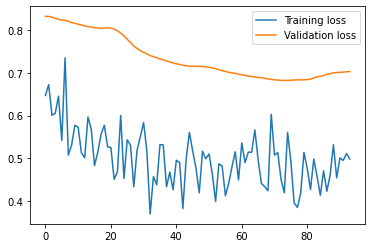

In [25]:
Cost_Predict = build_model(trainX, trainY, 200, 16)

Index(['2020-10-01', '2020-11-01'], dtype='object')


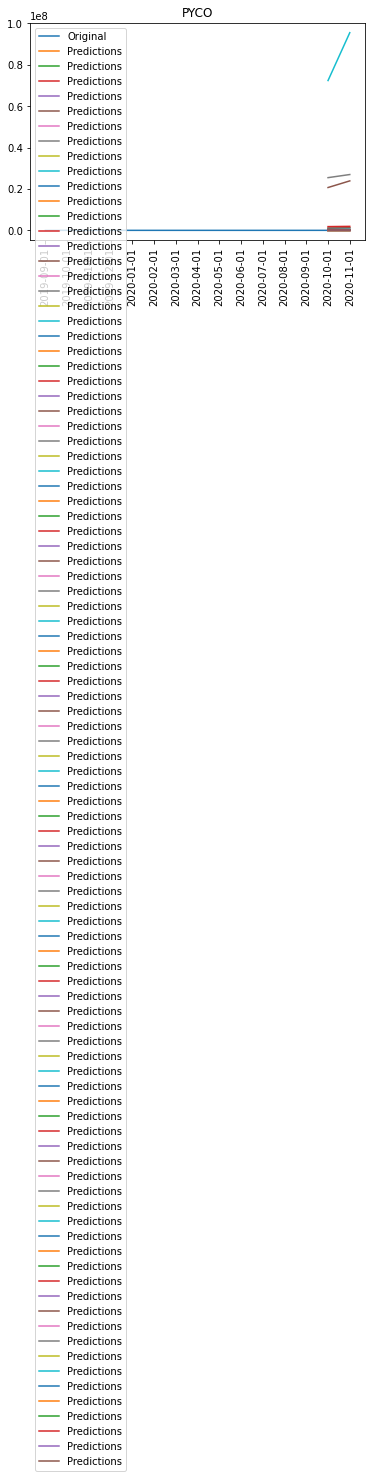

ValueError: y_true and y_pred have different number of output (95!=1)

In [26]:
evaluate_predictions(Cost_Predict, PYCO_dict)

Index(['2021-02-01', '2021-03-01'], dtype='object')


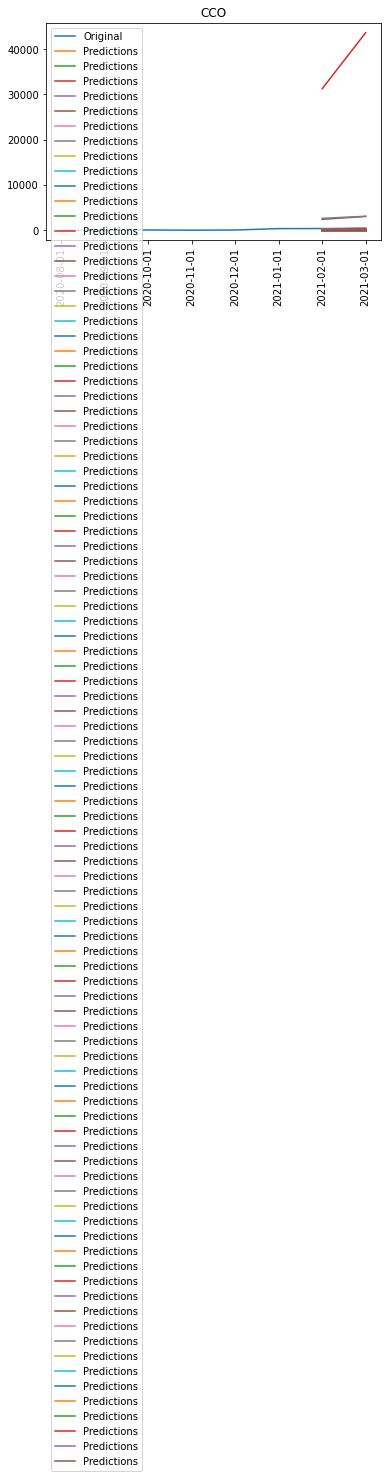

ValueError: y_true and y_pred have different number of output (95!=1)

In [27]:
evaluate_predictions(Cost_Predict, CCO_dict)

In [ ]:
evaluate_predictions(Cost_Predict, XCO_dict)